In [41]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy

In [42]:
d = 2

In [43]:
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    A = np.array([1, 0]) 
    #A = np.random.rand(2) + 1j * np.random.rand(2)
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [44]:
### (0, 0): (2, 2, 2) --> (2, 2, 2, 2)

shapes = {
    (0, 0): (2, 2, 2, 2),
    (0, 1): (2, 2, 2, 2),
    (0, 2): (2, 2, 2, 2),
    (0, 3): (2, 2),
    (1, 0): (2, 2, 2),
    (1, 1): (2, 2),
    (1, 2): (2, 2, 2),
    (1, 3): (2, 2),
    (2, 0): (2, 2, 2, 2),
    (2, 1): (2, 2, 2),
    (2, 2): (2, 2, 2),
    (2, 3): (2, 2),
    (3, 0): (2, 2),
    (3, 1): (2, 2, 2),
    (3, 2): (2, 2, 2, 2),
    (3, 3): (2, 2)
}

sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

ttn = product_state(ttn , bond_dim= 1, physical_dim = 2)  

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(4) for j in range(4)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

### (0,0) : 0,1 --> 1,2

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [45]:
def get_neighbors_periodic_in_legs(x, y, Lx, Ly):
  neighbors = []
  
  # Right neighbor (with periodic boundary)
  right_x = (x + 1) % Lx
  neighbors.append((f"Site({right_x},{y})"))
  
  # Up neighbor (with periodic boundary)
  up_y = (y + 1) % Ly
  neighbors.append((f"Site({x},{up_y})"))
  
  return neighbors

def get_neighbors_periodic_out_legs(x, y, Lx, Ly):
    neighbors = []
    
    # Right neighbor (with periodic boundary)
    right_x = (x + 1) % Lx
    neighbors.append((f"Node({right_x},{y})"))
    
    # Up neighbor (with periodic boundary)
    up_y = (y + 1) % Ly
    neighbors.append((f"Node({x},{up_y})"))
    
    return neighbors  



In [46]:
def Anisotropic_Heisenberg_ham(J_x, J_y, J_z, h_z, Lx, Ly):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create a conversion dictionary for the operators
    conversion_dict = {
        "X": X,
        "J_x * X": J_x * X,
        "Y": Y,
        "J_y * Y": J_y * Y,
        "Z": Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "h_z * Z": h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "Z", neighbor: "J_z * Z"}))               

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "h_z * Z"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

In [47]:
def Liouville_Heisenberg(Lx, Ly, J_x, J_y, J_z, h_z, L, J):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create the conversion dictionary for the Hamiltonian.
    conversion_dict = {
        "-iJ_x * X": -1j*J_x * (X),
        "X":                   (X),
        "-iJ_Y * Y": -1j*J_y * (Y),
        "Y":                   (Y),
        "-iJ_z * Z": -1j*J_z * (Z),
        "Z":                   (Z),
        "I2":          np.eye(2),
        "-ih_z * Z":  -1j* h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-iJ_x * X", neighbor: "X"}))
                terms.append(ptn.TensorProduct({current_site: "-iJ_Y * Y", neighbor: "Y"}))
                terms.append(ptn.TensorProduct({current_site: "-iJ_z * Z", neighbor: "Z"}))     

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-ih_z * Z"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    # H.T = H 
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "iJ_x * X.T": 1j*J_x * (X.T),
        "X.T":                 (X.T),
        "iJ_Y * Y.T": 1j*J_y * (Y.T),
        "Y.T":                 (Y.T),
        "iJ_z * Z.T": 1j*J_z * (Z.T),
        "Z.T":                 (Z.T),
        "I2":              np.eye(2),
        "ih_z * Z.T":     1j* h_z * (Z.T)
    }
    
    terms = []
    
    # Hopping terms for the transpose
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_periodic_out_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "iJ_x * X.T", neighbor: "X.T"}))
                terms.append(ptn.TensorProduct({current_site: "iJ_Y * Y.T", neighbor: "Y.T"}))
                terms.append(ptn.TensorProduct({current_site: "iJ_z * Z.T", neighbor: "Z.T"})) 


    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "ih_z * Z.T"}))
    
    H2 = ptn.Hamiltonian(terms, conversion_dict)    
    H1.__add__(H2)
    
    J = np.sqrt(J)
    conversion_dict = {
        "L": J * L,
        "L^dagger.T": J * L.conj(),
        "-1/2 (L^dagger @ L)": -1/2 * J * (L.conj().T @ L),
        "-1/2 (L^dagger @ L).T": -1/2 * J * (L.conj().T @ L).T
    }

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L)"}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    
    return H1

In [48]:
def Unitary(Lx, Ly, J_x, J_y, J_z, h_z):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "-i * X": -1j* X,
        "J_x * X": J_x * X,
        "-i * Y": -1j* Y,
        "J_y * Y": J_y * Y,
        "-i * Z": -1j* Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "-i * h_z * Z": -1j* h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-i * X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "-i * Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "-i * Z", neighbor: "J_z * Z"}))       

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-i * h_z * Z"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    # H.T = H 
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "i * X": 1j* X,
        "J_x * X": J_x * X,
        "i * Y": 1j* Y,
        "J_y * Y": J_y * Y,
        "i * Z": 1j* Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "i * h_z * Z": 1j* h_z * Z
    }
    
    terms = []
    
    # Hopping terms for the transpose
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_periodic_out_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "i * X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "i * Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "i * Z", neighbor: "J_z * Z"})) 


    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "i * h_z * Z"}))
    
    H2 = ptn.Hamiltonian(terms, conversion_dict)    
    H1.__add__(H2)
    
    return H1    
    

In [49]:
def Magnetization_op_total(Lx, Ly):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create a conversion dictionary for the operators
    conversion_dict = {
        "X": X ,
        "Y": Y,
        "Z": Z / (Lx*Ly),
        "I2": np.eye(2)}
    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "Z"}))  # Using Z for magnetization

    return ptn.Hamiltonian(terms, conversion_dict)

In [50]:
Lx =  4
Ly  = 4
J_x = 0.9
J_y = 1.8 #(1.8)
J_z = 1 
h_z = 1


# TTNO : Hamiltonian acting on in_legs
H1 = Anisotropic_Heisenberg_ham(J_x, J_y, J_z, h_z, Lx, Ly)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
X , Y , Z = ptn.pauli_matrices()
L = (X - 1j * Y) / 2
J = 1
H1 = Liouville_Heisenberg(Lx, Ly, J_x, J_y, J_z, h_z, L, J)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(Lx, Ly, J_x, J_y, J_z, h_z)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

M = Magnetization_op_total(Lx, Ly)
M = M.pad_with_identities(ttn, symbolic= True)
M = ptn.TTNO.from_hamiltonian(M, ttn)

ttn = ptn.normalize_ttn_Lindblad_4(ttn , 'Node(2,3)')
I = ptn.TTNO.Identity(ttn)
print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(M) / ttn.operator_expectation_value_Lindblad(I))

(1+0j)
(1+0j)


In [51]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.001,
                                     final_time = 4,
                                     operators = M,
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                                     expansion_steps = 200,
                                     t3n_dict = {'Site(0,0)': 'Site(1,0)',
                                                'Site(0,1)': 'Site(1,1)',
                                                'Site(0,2)': 'Site(0,3)',
                                                'Site(2,0)': 'Site(2,1)',
                                                'Site(3,2)': 'Site(3,3)',
                                                'Node(0,0)': 'Node(1,0)',
                                                'Node(0,1)': 'Node(1,1)',
                                                'Node(0,2)': 'Node(0,3)',
                                                'Node(2,0)': 'Node(2,1)',
                                                'Node(3,2)': 'Node(3,3)'},

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 

                                     initial_tol= 1e-16,
                                     tol_step= 50,
                                     rel_tot_bond = 30,
                                     max_bond= 220,
                                     norm_tol = 0,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [52]:
stop

NameError: name 'stop' is not defined

In [13]:
tdvp_ex1.run_ex(evaluation_time=2)


  0%|          | 0/401 [00:00<?, ?it/s]

M : (1+0j)


  0%|          | 2/401 [00:00<01:47,  3.72it/s]

M : (0.999205706965002+4.5208694136391123e-10j)


  1%|          | 4/401 [00:01<01:47,  3.71it/s]

M : (0.996835341821961+3.560869996177126e-09j)


  1%|▏         | 6/401 [00:01<01:37,  4.05it/s]

M : (0.9928796306346376+1.1816598284519383e-08j)


  2%|▏         | 8/401 [00:02<01:54,  3.44it/s]

M : (0.9872937195579662+2.750486942623821e-08j)


  2%|▏         | 10/401 [00:02<02:05,  3.11it/s]

M : (0.9799994718582475+5.268738991142694e-08j)


  3%|▎         | 12/401 [00:03<02:02,  3.17it/s]

M : (0.9708878535720177+8.919030192157795e-08j)


  4%|▎         | 15/401 [00:04<01:50,  3.48it/s]

M : (0.9598214990674306+1.3860163205425034e-07j)
SVD MAX : 1
tol : 1e-16


  4%|▍         | 17/401 [00:05<02:18,  2.76it/s]

31 31
4
expanded_dim T3NS: 0
T3NS: 41 ---> 41
expanded_dim TTN: 0
TTN: 31 ---> 31
M : (0.9466375762493747+2.0228021764630057e-07j)


  5%|▍         | 19/401 [00:05<01:51,  3.42it/s]

M : (0.9311510923719887+2.8137918722153163e-07j)


  5%|▍         | 20/401 [00:06<01:53,  3.36it/s]

M : (0.9131587944268837+3.768875850453162e-07j)


  5%|▌         | 22/401 [00:06<01:55,  3.29it/s]

M : (0.8924438210187035+4.896938735760028e-07j)


  6%|▌         | 25/401 [00:07<01:49,  3.42it/s]

M : (0.8687812529416926+6.206746372843764e-07j)


  6%|▋         | 26/401 [00:07<01:57,  3.19it/s]

M : (0.8419446843074849+7.708106697733564e-07j)


  7%|▋         | 29/401 [00:08<01:49,  3.41it/s]

M : (0.8117138920525973+9.413306156580663e-07j)


  7%|▋         | 30/401 [00:09<01:47,  3.44it/s]

M : (0.7778836166948533+1.1338793629146604e-06j)


  8%|▊         | 31/401 [00:09<01:50,  3.33it/s]

SVD MAX : 1
tol : 9.999999999999999e-18


  8%|▊         | 32/401 [00:10<03:08,  1.96it/s]

expanded_dim T3NS: 30
T3NS: 41 ---> 71
expanded_dim TTN: 24
TTN: 31 ---> 55
M : (0.7402733806164815+1.350704409231321e-06j)


  8%|▊         | 34/401 [00:10<02:16,  2.69it/s]

M : (0.6982637660128659+2.5604872301972968e-05j)


  9%|▉         | 37/401 [00:11<01:47,  3.39it/s]

M : (0.6516537731915486+0.00010186788776276129j)


  9%|▉         | 38/401 [00:11<01:47,  3.37it/s]

M : (0.6010005451494815+0.00022911644703806774j)


 10%|█         | 41/401 [00:12<01:28,  4.04it/s]

M : (0.5468795105648742+0.0004024567353484454j)


 10%|█         | 42/401 [00:12<01:31,  3.91it/s]

M : (0.4898192614152912+0.000621695246482503j)


 11%|█         | 44/401 [00:13<01:31,  3.91it/s]

M : (0.4302776059708654+0.0008973804437885064j)


 11%|█▏        | 46/401 [00:14<01:36,  3.69it/s]

M : (0.3686486831157245+0.0012499878893278925j)


 12%|█▏        | 47/401 [00:14<01:45,  3.35it/s]

SVD MAX : 4
tol : 9.999999999999999e-18


 12%|█▏        | 48/401 [00:16<04:24,  1.34it/s]

expanded_dim T3NS: 15
T3NS: 75 ---> 90
expanded_dim TTN: 10
TTN: 55 ---> 65
M : (0.3052837735723746+0.0017033666479184188j)


 12%|█▏        | 50/401 [00:16<03:12,  1.82it/s]

M : (0.2406022413125211+0.0023233462394456777j)


 13%|█▎        | 52/401 [00:17<02:28,  2.35it/s]

M : (0.17514888121779998+0.002975703126577175j)


 13%|█▎        | 54/401 [00:18<02:17,  2.53it/s]

M : (0.1094083074902262+0.003642505617561132j)


 14%|█▍        | 56/401 [00:18<02:10,  2.65it/s]

M : (0.04385504700624226+0.004290710789155226j)


 14%|█▍        | 58/401 [00:19<01:50,  3.11it/s]

M : (-0.021032009852483824+0.004881983771197736j)


 15%|█▍        | 60/401 [00:20<01:59,  2.86it/s]

M : (-0.08476068318524448+0.005378205409529843j)


 15%|█▌        | 62/401 [00:20<01:54,  2.97it/s]

M : (-0.1468191857951979+0.00574637891381862j)


 16%|█▌        | 63/401 [00:21<01:59,  2.84it/s]

SVD MAX : 6
tol : 9.999999999999999e-18


 16%|█▌        | 64/401 [00:23<05:27,  1.03it/s]

expanded_dim T3NS: 9
T3NS: 91 ---> 100
expanded_dim TTN: 6
TTN: 65 ---> 71
M : (-0.20667299556120836+0.005962142027301731j)


 16%|█▋        | 66/401 [00:24<03:28,  1.60it/s]

M : (-0.2632288457804132+0.005868669857385395j)


 17%|█▋        | 68/401 [00:25<02:40,  2.07it/s]

M : (-0.31617888953791506+0.005489434894421189j)


 17%|█▋        | 70/401 [00:25<02:13,  2.49it/s]

M : (-0.3650108931645015+0.0048460526651634295j)


 18%|█▊        | 72/401 [00:26<01:59,  2.76it/s]

M : (-0.40920901144746563+0.003979471663271328j)


 18%|█▊        | 74/401 [00:27<01:58,  2.77it/s]

M : (-0.44828375506825224+0.0029448197493832247j)


 19%|█▉        | 76/401 [00:27<01:46,  3.05it/s]

M : (-0.4817876176973782+0.0018014996452970038j)


 19%|█▉        | 78/401 [00:28<01:50,  2.91it/s]

M : (-0.5093369651114914+0.0005997163317672719j)


 20%|█▉        | 79/401 [00:28<01:52,  2.87it/s]

SVD MAX : 6
tol : 9.999999999999999e-18


 20%|█▉        | 80/401 [00:30<04:39,  1.15it/s]

expanded_dim T3NS: 11
T3NS: 101 ---> 112
expanded_dim TTN: 10
TTN: 71 ---> 81
M : (-0.5306410579476251-0.0006356465145400227j)


 20%|██        | 82/401 [00:31<03:04,  1.73it/s]

M : (-0.5452214956667969-0.0020190173303338958j)


 21%|██        | 84/401 [00:32<02:21,  2.24it/s]

M : (-0.5534435861688318-0.003579049407476994j)


 21%|██▏       | 86/401 [00:32<02:06,  2.49it/s]

M : (-0.5555821304190249-0.005484850522247803j)


 22%|██▏       | 88/401 [00:33<01:51,  2.80it/s]

M : (-0.5521226659529124-0.007960164169687233j)


 22%|██▏       | 90/401 [00:34<01:49,  2.84it/s]

M : (-0.5437575873402051-0.01125677592992993j)


 23%|██▎       | 92/401 [00:34<01:48,  2.86it/s]

M : (-0.5313418837956918-0.015610463721757515j)


 23%|██▎       | 94/401 [00:35<01:37,  3.14it/s]

M : (-0.5158150882179156-0.021193760823555993j)


 24%|██▎       | 95/401 [00:35<01:35,  3.20it/s]

SVD MAX : 8
tol : 9.999999999999999e-18


 24%|██▍       | 96/401 [00:39<06:21,  1.25s/it]

expanded_dim T3NS: 14
T3NS: 120 ---> 134
expanded_dim TTN: 13
TTN: 81 ---> 94
M : (-0.49810020860847487-0.028082774008971318j)


 24%|██▍       | 98/401 [00:39<04:08,  1.22it/s]

M : (-0.4770582165087175-0.03483195919879169j)


 25%|██▍       | 100/401 [00:40<03:04,  1.63it/s]

M : (-0.45445077514504884-0.04210127620416051j)


 25%|██▌       | 102/401 [00:41<02:40,  1.86it/s]

M : (-0.4305562394194725-0.04975196531266416j)


 26%|██▌       | 104/401 [00:42<02:31,  1.96it/s]

M : (-0.40530810438197684-0.05742599089446446j)


 26%|██▋       | 106/401 [00:43<02:23,  2.05it/s]

M : (-0.3783753452875148-0.064748559062071j)


 27%|██▋       | 108/401 [00:44<02:14,  2.18it/s]

M : (-0.34921410897772-0.0713415259957413j)


 27%|██▋       | 110/401 [00:45<02:09,  2.24it/s]

M : (-0.3171658212958943-0.07680749126605543j)


 28%|██▊       | 111/401 [00:45<02:12,  2.18it/s]

SVD MAX : 8
tol : 9.999999999999999e-18


 28%|██▊       | 112/401 [00:49<07:00,  1.46s/it]

expanded_dim T3NS: 34
T3NS: 136 ---> 170
expanded_dim TTN: 29
TTN: 94 ---> 123
M : (-0.2815998993885398-0.08070332286467083j)


 28%|██▊       | 114/401 [00:50<05:00,  1.05s/it]

M : (-0.2466067380724124-0.08543892547918702j)


 29%|██▉       | 116/401 [00:52<04:04,  1.17it/s]

M : (-0.2086652103401733-0.09012966571288047j)


 29%|██▉       | 118/401 [00:53<03:36,  1.31it/s]

M : (-0.16771295733983857-0.0946216628672886j)


 30%|██▉       | 120/401 [00:54<03:19,  1.41it/s]

M : (-0.12387065089981485-0.09877727932941742j)


 30%|███       | 122/401 [00:56<03:03,  1.52it/s]

M : (-0.0775025644586012-0.10235375629244964j)


 31%|███       | 124/401 [00:57<02:50,  1.62it/s]

M : (-0.029372631309462917-0.10499774600092854j)


 31%|███▏      | 126/401 [00:58<02:54,  1.58it/s]

M : (0.019222688159843057-0.1062915753212568j)


 32%|███▏      | 127/401 [00:59<02:49,  1.61it/s]

SVD MAX : 12
tol : 9.999999999999999e-18
expanded_dim_tot : 44
1) tol 1e-16


 32%|███▏      | 128/401 [01:10<16:57,  3.73s/it]

2) expanded_dim : 2
expanded_dim T3NS: 3
T3NS: 175 ---> 178
expanded_dim TTN: 2
TTN: 123 ---> 125
M : (0.0664694554053148-0.1058714144491381j)


 32%|███▏      | 130/401 [01:11<09:48,  2.17s/it]

M : (0.11023483370951823-0.10347170590138073j)


 33%|███▎      | 132/401 [01:12<06:14,  1.39s/it]

M : (0.14864472560159392-0.09921949725560636j)


 33%|███▎      | 134/401 [01:13<04:14,  1.05it/s]

M : (0.18028158005325534-0.09324167930282448j)


 34%|███▍      | 136/401 [01:14<03:14,  1.36it/s]

M : (0.2040780125291413-0.08561103177041308j)


 34%|███▍      | 138/401 [01:16<02:51,  1.54it/s]

M : (0.2191813714837896-0.0765666959261657j)


 35%|███▍      | 140/401 [01:17<02:29,  1.75it/s]

M : (0.22502840854005818-0.06669658291563207j)


 35%|███▌      | 142/401 [01:18<02:34,  1.68it/s]

M : (0.22162959577431068-0.056797990707188904j)


 36%|███▌      | 143/401 [01:18<02:32,  1.69it/s]

SVD MAX : 12
tol : 1e-16


 36%|███▌      | 144/401 [01:25<10:35,  2.47s/it]

expanded_dim T3NS: -6
T3NS: 185 ---> 179
expanded_dim TTN: 2
TTN: 125 ---> 127
M : (0.20968823640780415-0.04750257501094432j)


 36%|███▋      | 146/401 [01:27<06:35,  1.55s/it]

M : (0.19050705024955197-0.039284008421592645j)


 37%|███▋      | 148/401 [01:27<04:12,  1.00it/s]

M : (0.1653228687264294-0.03178947887715061j)


 37%|███▋      | 150/401 [01:29<03:15,  1.28it/s]

M : (0.13536800345726016-0.02453152360234872j)


 38%|███▊      | 152/401 [01:30<02:36,  1.59it/s]

M : (0.10172283037041085-0.01707258396210597j)


 38%|███▊      | 154/401 [01:31<02:30,  1.64it/s]

M : (0.06542896960477194-0.009087304424961945j)


 39%|███▉      | 156/401 [01:32<02:29,  1.64it/s]

M : (0.027592795174226255-0.0004010727007096332j)


 39%|███▉      | 158/401 [01:33<02:18,  1.76it/s]

M : (-0.010563127776332146+0.008996989226234535j)


 40%|███▉      | 159/401 [01:34<02:17,  1.77it/s]

SVD MAX : 12
tol : 1e-16


 40%|███▉      | 160/401 [01:40<08:52,  2.21s/it]

expanded_dim T3NS: 4
T3NS: 181 ---> 185
expanded_dim TTN: 4
TTN: 127 ---> 131
M : (-0.04771383232500971+0.01895395494741252j)


 40%|████      | 162/401 [01:41<05:40,  1.42s/it]

M : (-0.08255891152939984+0.029096484403104406j)


 41%|████      | 164/401 [01:42<04:04,  1.03s/it]

M : (-0.11366688431516456+0.03907547202385906j)


 41%|████▏     | 166/401 [01:44<03:22,  1.16it/s]

M : (-0.139670956917484+0.04841477032561985j)


 42%|████▏     | 168/401 [01:45<02:52,  1.35it/s]

M : (-0.15925258294779146+0.05664937304075414j)


 42%|████▏     | 170/401 [01:46<02:35,  1.48it/s]

M : (-0.17110610357211795+0.06337228810588734j)


 43%|████▎     | 172/401 [01:47<02:22,  1.61it/s]

M : (-0.17395374697839433+0.06827433400391038j)


 43%|████▎     | 174/401 [01:49<02:25,  1.56it/s]

M : (-0.16663519127880286+0.07119449721638016j)


 44%|████▎     | 175/401 [01:49<02:30,  1.50it/s]

SVD MAX : 12
tol : 1e-16


 44%|████▍     | 176/401 [01:54<07:18,  1.95s/it]

expanded_dim T3NS: 4
T3NS: 185 ---> 189
expanded_dim TTN: 4
TTN: 131 ---> 135
M : (-0.14829812086493468+0.07220875389647968j)


 44%|████▍     | 178/401 [01:55<04:04,  1.10s/it]

M : (-0.11876527061150881+0.07191746154375882j)


 45%|████▍     | 180/401 [01:56<02:29,  1.48it/s]

M : (-0.07906046442191464+0.07119509226394033j)


 45%|████▌     | 182/401 [01:56<01:42,  2.13it/s]

M : (-0.031957390737275444+0.07180370983058322j)


 46%|████▌     | 184/401 [01:57<01:20,  2.71it/s]

M : (0.017427640783011976+0.07604966682238613j)


 46%|████▋     | 186/401 [01:57<01:09,  3.11it/s]

M : (0.061752588772933666+0.08604203872851403j)


 47%|████▋     | 188/401 [01:58<01:02,  3.42it/s]

M : (0.09286212031385808+0.10237490216407168j)


 47%|████▋     | 190/401 [01:58<00:58,  3.63it/s]

M : (0.10448834575651389+0.12314752278065208j)


 48%|████▊     | 191/401 [01:59<01:00,  3.48it/s]

SVD MAX : 12
tol : 1e-16


 48%|████▊     | 192/401 [02:02<04:20,  1.25s/it]

expanded_dim T3NS: 18
T3NS: 192 ---> 210
expanded_dim TTN: 16
TTN: 135 ---> 151
M : (0.09490056099509714+0.1445080797339079j)


 48%|████▊     | 194/401 [02:03<02:47,  1.24it/s]

M : (0.06716081067419839+0.16156432759545494j)


 49%|████▉     | 196/401 [02:04<02:00,  1.70it/s]

M : (0.028865658444543075+0.1727827507639287j)


 49%|████▉     | 198/401 [02:04<01:37,  2.08it/s]

M : (-0.01227512315762807+0.17858875215740808j)


 50%|████▉     | 200/401 [02:05<01:29,  2.25it/s]

M : (-0.04993323269521267+0.18039643271438413j)


 50%|█████     | 202/401 [02:06<01:21,  2.44it/s]

M : (-0.0794051317299942+0.17998557978350502j)


 51%|█████     | 204/401 [02:07<01:18,  2.52it/s]

M : (-0.09757996624812011+0.17909962920395947j)


 51%|█████▏    | 206/401 [02:07<01:15,  2.59it/s]

M : (-0.10305731645522498+0.1793492980956315j)


 52%|█████▏    | 207/401 [02:08<01:17,  2.51it/s]

SVD MAX : 16
tol : 1e-16


 52%|█████▏    | 208/401 [02:14<06:57,  2.16s/it]

expanded_dim T3NS: 21
T3NS: 227 ---> 248
expanded_dim TTN: 19
TTN: 151 ---> 170
M : (-0.09672008590881245+0.18220927787133162j)


 52%|█████▏    | 210/401 [02:15<04:15,  1.34s/it]

M : (-0.08316566819076264+0.1885810005616984j)


 53%|█████▎    | 212/401 [02:16<02:54,  1.08it/s]

M : (-0.0693148970794033+0.19878063152100078j)


 53%|█████▎    | 214/401 [02:17<02:11,  1.42it/s]

M : (-0.06384206449082128+0.21012981185689258j)


 54%|█████▍    | 216/401 [02:18<01:54,  1.62it/s]

M : (-0.0733796034672775+0.2179658341112055j)


 54%|█████▍    | 218/401 [02:19<01:41,  1.81it/s]

M : (-0.0995718287407691+0.21802275521700204j)


 55%|█████▍    | 220/401 [02:20<01:36,  1.87it/s]

M : (-0.1391629334630995+0.20890857457888326j)


 55%|█████▌    | 222/401 [02:21<01:37,  1.84it/s]

M : (-0.1863268302109133+0.19243929203435897j)


 56%|█████▌    | 223/401 [02:22<01:38,  1.81it/s]

SVD MAX : 18
tol : 1e-16


 56%|█████▌    | 224/401 [02:30<08:13,  2.79s/it]

expanded_dim T3NS: 13
T3NS: 264 ---> 277
expanded_dim TTN: 18
TTN: 170 ---> 188
M : (-0.23494514269358083+0.172238111622513j)


 56%|█████▋    | 226/401 [02:31<05:04,  1.74s/it]

M : (-0.2791135574401639+0.15224479735460728j)


 57%|█████▋    | 228/401 [02:33<03:31,  1.22s/it]

M : (-0.31557022463362816+0.13641971960781973j)


 57%|█████▋    | 230/401 [02:34<02:44,  1.04it/s]

M : (-0.3426717297289355+0.1280399116300845j)


 58%|█████▊    | 232/401 [02:36<02:21,  1.20it/s]

M : (-0.3607382999241538+0.1294787176213953j)


 58%|█████▊    | 234/401 [02:37<02:06,  1.32it/s]

M : (-0.37201932860723136+0.14144460563388694j)


 59%|█████▉    | 236/401 [02:39<01:59,  1.39it/s]

M : (-0.3798996935802138+0.16219346068107257j)


 59%|█████▉    | 238/401 [02:40<01:54,  1.42it/s]

M : (-0.38760502364528904+0.18750334925942683j)


 60%|█████▉    | 239/401 [02:41<01:52,  1.44it/s]

SVD MAX : 22
tol : 1e-16


 60%|█████▉    | 240/401 [02:53<10:55,  4.07s/it]

expanded_dim T3NS: 3
T3NS: 294 ---> 297
expanded_dim TTN: 13
TTN: 188 ---> 201
M : (-0.3972080697603978+0.2118267220202787j)


 60%|██████    | 242/401 [02:54<06:32,  2.47s/it]

M : (-0.4093443170970967+0.2294814157593571j)


 61%|██████    | 244/401 [02:56<04:24,  1.69s/it]

M : (-0.4243924452848979+0.23760038836039887j)


 61%|██████▏   | 246/401 [02:58<03:24,  1.32s/it]

M : (-0.442756282127332+0.23555153381653451j)


 62%|██████▏   | 248/401 [03:00<02:44,  1.08s/it]

M : (-0.4645898410920608+0.22469676693540508j)


 62%|██████▏   | 250/401 [03:02<02:26,  1.03it/s]

M : (-0.4895714417067609+0.20769658027128796j)


 63%|██████▎   | 252/401 [03:03<02:15,  1.10it/s]

M : (-0.5167072072697421+0.1876043992787401j)


 63%|██████▎   | 254/401 [03:05<02:07,  1.15it/s]

M : (-0.5444548091250926+0.16720340546338086j)


 64%|██████▎   | 255/401 [03:06<02:07,  1.14it/s]

SVD MAX : 24
tol : 1e-16


 64%|██████▍   | 256/401 [03:20<11:58,  4.96s/it]

expanded_dim T3NS: 0
T3NS: 315 ---> 315
expanded_dim TTN: 9
TTN: 201 ---> 210
M : (-0.5710651691506808+0.1487288818778179j)


 64%|██████▍   | 258/401 [03:23<07:15,  3.05s/it]

M : (-0.5945251552278242+0.1337667828667879j)


 65%|██████▍   | 260/401 [03:25<04:53,  2.08s/it]

M : (-0.6139424607160815+0.12378785982798964j)


 65%|██████▌   | 262/401 [03:27<03:41,  1.59s/it]

M : (-0.6287285364812303+0.11991006644723626j)


 66%|██████▌   | 264/401 [03:30<03:06,  1.36s/it]

M : (-0.6387841809105519+0.12304295039051583j)


 66%|██████▋   | 266/401 [03:32<02:48,  1.25s/it]

M : (-0.6444446982138581+0.13383149393992116j)


 67%|██████▋   | 268/401 [03:34<02:44,  1.24s/it]

M : (-0.6462264640449243+0.15259649594705668j)


 67%|██████▋   | 270/401 [03:37<02:35,  1.19s/it]

M : (-0.6445902205485663+0.17937363604960999j)


 68%|██████▊   | 271/401 [03:38<02:33,  1.18s/it]

SVD MAX : 26
tol : 1e-16
expanded_dim_tot : 43
1) tol 1e-15


 68%|██████▊   | 272/401 [04:12<24:07, 11.22s/it]

2) expanded_dim : 1
expanded_dim T3NS: -13
T3NS: 332 ---> 319
expanded_dim TTN: 1
TTN: 210 ---> 211
M : (-0.6400748425648483+0.21396558691519166j)


 68%|██████▊   | 274/401 [04:15<12:47,  6.04s/it]

M : (-0.6337393127447284+0.2551316968764838j)


 69%|██████▉   | 276/401 [04:17<07:19,  3.52s/it]

M : (-0.6278200971248787+0.3005849657377811j)


 69%|██████▉   | 278/401 [04:19<04:40,  2.28s/it]

M : (-0.6246954325741626+0.3451410795437726j)


 70%|██████▉   | 280/401 [04:21<03:21,  1.66s/it]

M : (-0.6255813901679705+0.38241422392423197j)


 70%|███████   | 282/401 [04:23<02:47,  1.41s/it]

M : (-0.6308753709716677+0.4075873125357751j)


 71%|███████   | 284/401 [04:25<02:22,  1.21s/it]

M : (-0.6412328601714822+0.41922797319663363j)


 71%|███████▏  | 286/401 [04:28<02:13,  1.16s/it]

M : (-0.6577611257203975+0.419514105966992j)


 72%|███████▏  | 287/401 [04:29<02:07,  1.12s/it]

SVD MAX : 26
tol : 1e-15


 72%|███████▏  | 288/401 [04:44<10:13,  5.43s/it]

expanded_dim T3NS: -10
T3NS: 333 ---> 323
expanded_dim TTN: 3
TTN: 211 ---> 214
M : (-0.6812900088173985+0.41334963587590656j)


 72%|███████▏  | 290/401 [04:46<05:58,  3.23s/it]

M : (-0.7114733043096174+0.40689427066523487j)


 73%|███████▎  | 292/401 [04:49<04:01,  2.22s/it]

M : (-0.7473220913498013+0.4067750909237916j)


 73%|███████▎  | 294/401 [04:53<03:34,  2.00s/it]

M : (-0.7871219547916855+0.4200413480935096j)


 74%|███████▍  | 296/401 [04:56<03:02,  1.74s/it]

M : (-0.8280524097386951+0.45476844137698735j)


 74%|███████▍  | 298/401 [05:00<03:14,  1.89s/it]

M : (-0.8645662609115+0.5216054312412499j)


 75%|███████▍  | 300/401 [05:02<02:43,  1.62s/it]

M : (-0.8829124529054501+0.6351284539095177j)


 75%|███████▌  | 302/401 [05:05<02:34,  1.56s/it]

M : (-0.8471356406393683+0.8095726239030492j)


 76%|███████▌  | 303/401 [05:07<02:35,  1.59s/it]

SVD MAX : 28
tol : 1e-15


 76%|███████▌  | 304/401 [05:32<13:49,  8.55s/it]

220 225
3
214 214
4
expanded_dim T3NS: -6
T3NS: 340 ---> 334
expanded_dim TTN: 0
TTN: 214 ---> 214
M : (-0.6787487295277177+1.0241113842986236j)


 76%|███████▋  | 306/401 [05:36<08:19,  5.26s/it]

M : (-0.31217290212604065+1.1278291624819397j)


 77%|███████▋  | 308/401 [05:40<05:42,  3.69s/it]

M : (0.06474318522789953+0.9275543791446712j)


 77%|███████▋  | 310/401 [05:44<04:20,  2.87s/it]

M : (0.18791517340035663+0.5853578951365245j)


 78%|███████▊  | 312/401 [05:49<03:42,  2.50s/it]

M : (0.13131954191260947+0.3320686214816854j)


 78%|███████▊  | 314/401 [05:53<03:27,  2.38s/it]

M : (0.032347994685577766+0.1866942505047482j)


 79%|███████▉  | 316/401 [05:58<03:12,  2.26s/it]

M : (-0.0565256143055958+0.1067917229135048j)


 79%|███████▉  | 318/401 [06:01<02:45,  2.00s/it]

M : (-0.12460093704084499+0.062317739411772384j)


 80%|███████▉  | 320/401 [06:04<02:24,  1.78s/it]

M : (-0.17232157636217457+0.037805703935109715j)


 80%|████████  | 322/401 [06:07<02:03,  1.57s/it]

M : (-0.20200780794958845+0.0257527683665351j)


 81%|████████  | 324/401 [06:10<01:59,  1.56s/it]

M : (-0.21580288401200284+0.022399073393769866j)


 81%|████████▏ | 326/401 [06:13<01:49,  1.45s/it]

M : (-0.21545203211686056+0.02554376535735816j)


 82%|████████▏ | 328/401 [06:15<01:33,  1.28s/it]

M : (-0.20243677363534124+0.03340499552529032j)


 82%|████████▏ | 330/401 [06:18<01:34,  1.33s/it]

M : (-0.1781637260707242+0.04399382053251842j)


 83%|████████▎ | 332/401 [06:21<01:40,  1.45s/it]

M : (-0.14423633055441615+0.05480922737579567j)


 83%|████████▎ | 334/401 [06:24<01:37,  1.45s/it]

M : (-0.10284849112997334+0.06285740314302403j)


 84%|████████▍ | 336/401 [06:27<01:38,  1.51s/it]

M : (-0.057201300553909346+0.06508987273053375j)


 84%|████████▍ | 338/401 [06:30<01:38,  1.56s/it]

M : (-0.01163568390640421+0.059309721598439086j)


 85%|████████▍ | 340/401 [06:32<01:22,  1.35s/it]

M : (0.02894078001431451+0.0452806775890763j)


 85%|████████▌ | 342/401 [06:35<01:14,  1.27s/it]

M : (0.06040968517042194+0.025320573972037477j)


 86%|████████▌ | 344/401 [06:37<01:08,  1.21s/it]

M : (0.08087311908504088+0.0037427025467185486j)


 86%|████████▋ | 346/401 [06:39<01:05,  1.18s/it]

M : (0.09109738873073975-0.01462310870941389j)


 87%|████████▋ | 348/401 [06:42<01:06,  1.25s/it]

M : (0.09358874802982818-0.025897534139989745j)


 87%|████████▋ | 350/401 [06:44<01:02,  1.23s/it]

M : (0.09096271319665633-0.027965264648009j)


 88%|████████▊ | 352/401 [06:47<01:05,  1.33s/it]

M : (0.08467128529982212-0.02071044018393955j)


 88%|████████▊ | 354/401 [06:50<01:06,  1.42s/it]

M : (0.07475370866766878-0.005931922989761811j)


 89%|████████▉ | 356/401 [06:53<01:03,  1.40s/it]

M : (0.0605074558089074+0.013111331107765974j)


 89%|████████▉ | 358/401 [06:56<00:56,  1.32s/it]

M : (0.04137133363644487+0.0326206867500783j)


 90%|████████▉ | 360/401 [06:58<00:52,  1.29s/it]

M : (0.017368385074780144+0.049344701297516336j)


 90%|█████████ | 362/401 [07:00<00:46,  1.19s/it]

M : (-0.010955275252072575+0.06133172753865173j)


 91%|█████████ | 364/401 [07:03<00:43,  1.17s/it]

M : (-0.04278562654035647+0.06811927330088534j)


 91%|█████████▏| 366/401 [07:05<00:41,  1.19s/it]

M : (-0.07725445700139455+0.07046374211884254j)


 92%|█████████▏| 368/401 [07:07<00:38,  1.16s/it]

M : (-0.1135475041964587+0.06985204571761879j)


 92%|█████████▏| 370/401 [07:09<00:35,  1.14s/it]

M : (-0.1509280809696573+0.06802574033908733j)


 93%|█████████▎| 372/401 [07:12<00:33,  1.15s/it]

M : (-0.18872397417997286+0.06664649277529595j)


 93%|█████████▎| 374/401 [07:14<00:31,  1.15s/it]

M : (-0.22631109015069956+0.06711961247910349j)


 94%|█████████▍| 376/401 [07:16<00:28,  1.15s/it]

M : (-0.2630878454498948+0.07054405490769866j)


 94%|█████████▍| 378/401 [07:19<00:26,  1.14s/it]

M : (-0.2984221434874182+0.077756010666737j)


 95%|█████████▍| 380/401 [07:21<00:24,  1.17s/it]

M : (-0.3315793331531846+0.08942945160093349j)


 95%|█████████▌| 382/401 [07:23<00:21,  1.16s/it]

M : (-0.36165292424751433+0.10619649938342242j)


 96%|█████████▌| 384/401 [07:26<00:19,  1.15s/it]

M : (-0.3875098303654891+0.12876277139824724j)


 96%|█████████▋| 386/401 [07:28<00:17,  1.16s/it]

M : (-0.4077487653313099+0.15797652000307988j)


 97%|█████████▋| 388/401 [07:30<00:15,  1.17s/it]

M : (-0.42063678531623233+0.1947643211560155j)


 97%|█████████▋| 390/401 [07:33<00:12,  1.16s/it]

M : (-0.42393949988697466+0.23982032219516525j)


 98%|█████████▊| 392/401 [07:35<00:10,  1.15s/it]

M : (-0.41458731404715876+0.29290251047425525j)


 98%|█████████▊| 394/401 [07:37<00:08,  1.17s/it]

M : (-0.3883703695991257+0.3515401974748835j)


 99%|█████████▉| 396/401 [07:40<00:05,  1.16s/it]

M : (-0.3404559329711407+0.409112453405266j)


 99%|█████████▉| 398/401 [07:42<00:03,  1.16s/it]

M : (-0.268213764153049+0.45318038978665104j)


100%|█████████▉| 400/401 [07:44<00:01,  1.17s/it]

M : (-0.17698860413605333+0.467158023334148j)


100%|██████████| 401/401 [07:45<00:00,  1.16s/it]


In [15]:
times = tdvp_ex1.times()
tdvp_ex1.operator_results()[0]

array([ 1.        +0.00000000e+00j,  0.99920571+4.52086941e-10j,
        0.99683534+3.56087000e-09j,  0.99287963+1.18165983e-08j,
        0.98729372+2.75048694e-08j,  0.97999947+5.26873899e-08j,
        0.97088785+8.91903019e-08j,  0.9598215 +1.38601632e-07j,
        0.94663758+2.02280218e-07j,  0.93115109+2.81379187e-07j,
        0.91315879+3.76887585e-07j,  0.89244382+4.89693874e-07j,
        0.86878125+6.20674637e-07j,  0.84194468+7.70810670e-07j,
        0.81171389+9.41330616e-07j,  0.77788362+1.13387936e-06j,
        0.74027338+1.35070441e-06j,  0.69826377+2.56048723e-05j,
        0.65165377+1.01867888e-04j,  0.60100055+2.29116447e-04j,
        0.54687951+4.02456735e-04j,  0.48981926+6.21695246e-04j,
        0.43027761+8.97380444e-04j,  0.36864868+1.24998789e-03j,
        0.30528377+1.70336665e-03j,  0.24060224+2.32334624e-03j,
        0.17514888+2.97570313e-03j,  0.10940831+3.64250562e-03j,
        0.04385505+4.29071079e-03j, -0.02103201+4.88198377e-03j,
       -0.08476068+5.3782

C:\Users\edpou\AppData\Local\Temp\ipykernel_9064\2378592497.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


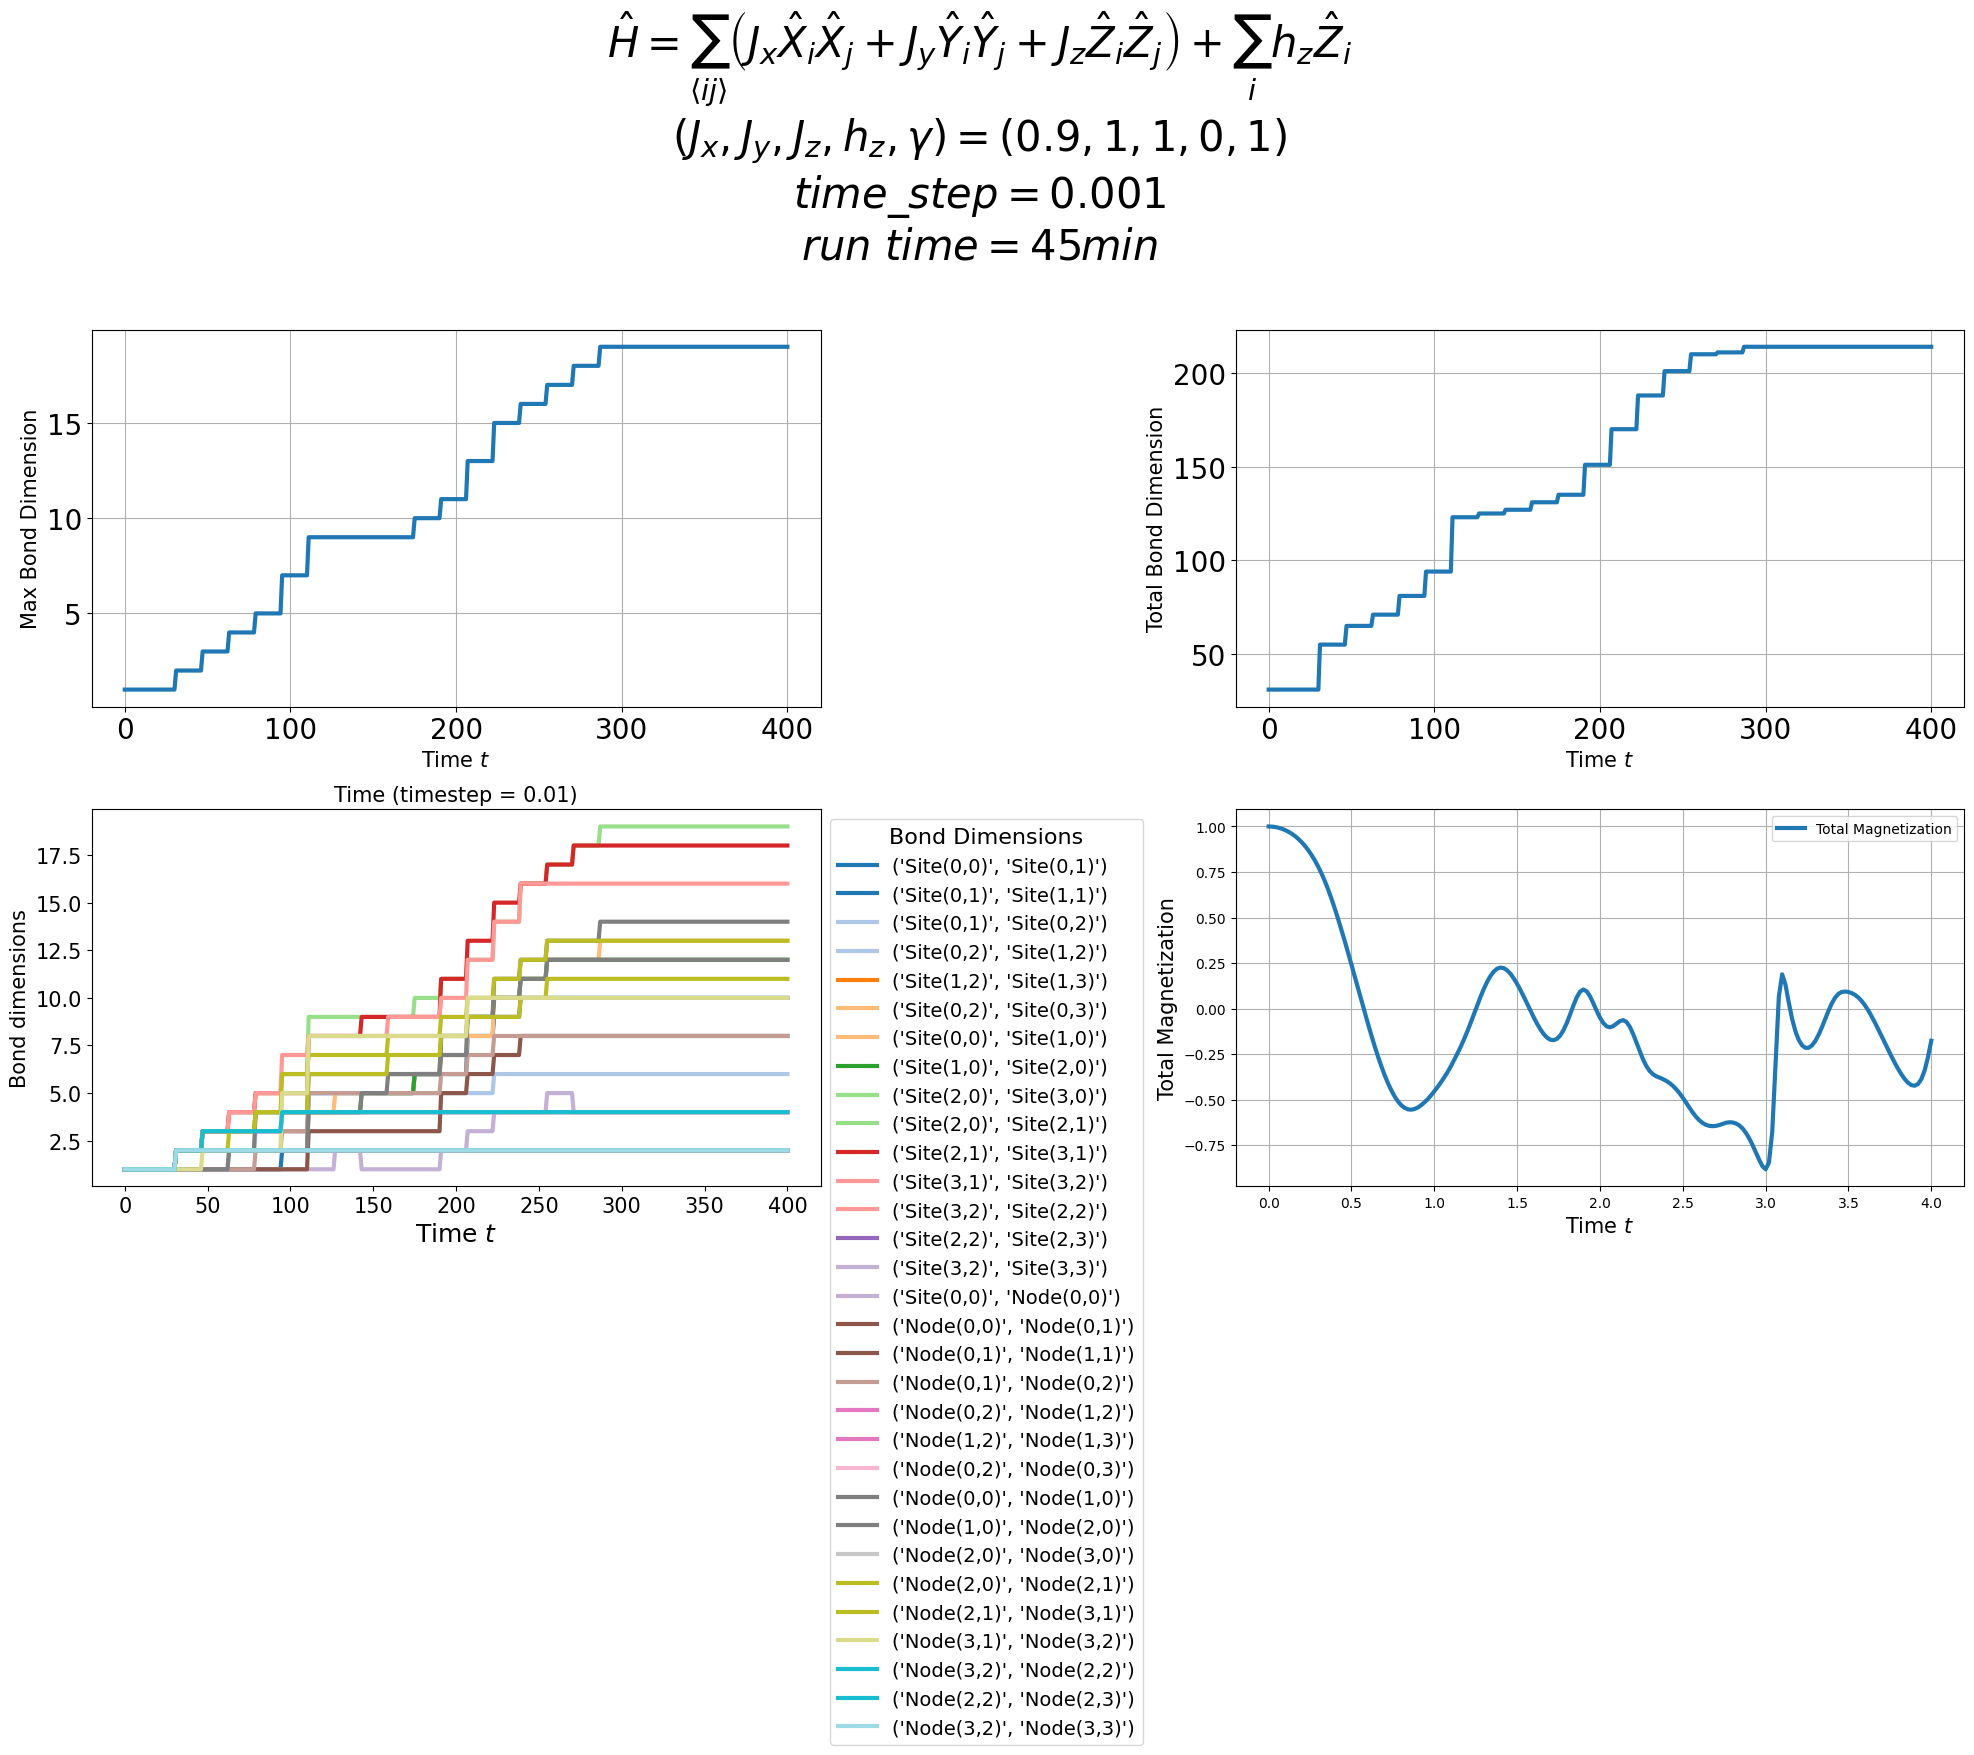

In [16]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Set a title for the entire figure
plt.suptitle(
    r'$\hat{H}=\sum_{\langle i j\rangle}\left(J_x \hat{X}_i \hat{X}_j+J_y \hat{Y}_i \hat{Y}_j+J_z \hat{Z}_i \hat{Z}_j\right)+\sum_i h_z \hat{Z}_i$' + '\n' + 
    r'$(J_x,J_y,J_z,h_z,\gamma) = (0.9, 1, 1, 0, 1) $' + '\n' +
    r'$time\_step = 0.001$' + '\n' +
    r'$run\ time = 45 min $',
    fontsize=30, y=0.98
)

# Plot max bond dimension
axs[0, 0].plot(tdvp_ex1.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp_ex1.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)

# Plot results_M
axs[1, 1].plot(times , tdvp_ex1.operator_results()[0], label="Total Magnetization", linewidth=3)
axs[1, 1].set_xlabel("Time $t$", fontsize=15)
axs[1, 1].set_ylabel("Total Magnetization", fontsize=15)
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


In [ ]:
### (0, 0): (2, 2, 2) --> (2, 2, 2, 2)

shapes = {
    (0, 0): (2, 2, 2),
    (0, 1): (2, 2, 2),
    (0, 2): (2, 2, 2, 2),
    (0, 3): (2, 2),
    (1, 0): (2, 2),
    (1, 1): (2, 2, 2, 2),
    (1, 2): (2, 2, 2, 2),
    (1, 3): (2, 2),
    (2, 0): (2, 2),
    (2, 1): (2, 2, 2, 2),
    (2, 2): (2, 2, 2, 2),
    (2, 3): (2, 2),
    (3, 0): (2, 2),
    (3, 1): (2, 2, 2),
    (3, 2): (2, 2, 2, 2),
    (3, 3): (2, 2)
}

sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (0, 3), 1, 0),
    ((0, 2), (1, 2), 2, 0),
    ((1, 2), (1, 3), 1, 0),
    ((1, 2), (1, 1), 2, 0),
    ((1, 1), (1, 0), 1, 0),
    ((1, 1), (2, 1), 2, 0),
    ((2, 1), (2, 0), 1, 0),
    ((2, 1), (2, 2), 2, 0),
    ((2, 2), (2, 3), 1, 0),
    ((2, 2), (3, 2), 2, 0),
    ((3, 2), (3, 3), 1, 0),
    ((3, 2), (3, 1), 2, 0),
    ((3, 1), (3, 0), 1, 0),
    ]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

ttn = product_state(ttn , bond_dim= 2, physical_dim = 2)  

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(4) for j in range(4)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 1, "Site(0,0)", 1)

### (0,0) : 0,1 --> 1,2

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (0, 3), 1, 0),
    ((0, 2), (1, 2), 2, 0),
    ((1, 2), (1, 3), 1, 0),
    ((1, 2), (1, 1), 2, 0),
    ((1, 1), (1, 0), 1, 0),
    ((1, 1), (2, 1), 2, 0),
    ((2, 1), (2, 0), 1, 0),
    ((2, 1), (2, 2), 2, 0),
    ((2, 2), (2, 3), 1, 0),
    ((2, 2), (3, 2), 2, 0),
    ((3, 2), (3, 3), 1, 0),
    ((3, 2), (3, 1), 2, 0),
    ((3, 1), (3, 0), 1, 0),
    ]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [ ]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 4,
                                     operators = M,
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                                     expansion_steps = 15,
                                     t3n_dict = {'Site(0,2)': 'Site(0,1)',
                                                'Site(1,2)': 'Site(1,1)',
                                                'Site(1,1)': 'Site(2,1)',
                                                'Site(2,1)': 'Site(2,2)',
                                                'Site(2,2)': 'Site(2,1)',
                                                'Site(3,2)': 'Site(3,3)',

                                                'Node(0,2)': 'Node(0,1)',
                                                'Node(1,2)': 'Node(1,1)',
                                                'Node(1,1)': 'Node(2,1)',
                                                'Node(2,1)': 'Node(2,2)',
                                                'Node(2,2)': 'Node(2,1)',
                                                'Node(3,2)': 'Node(3,3)'},

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 

                                     initial_tol= 1e-16,
                                     tol_step= 10,
                                     rel_tot_bond = 30,
                                     max_bond= 220,
                                     norm_tol = 0,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )